# Aquaseca basic domain
## Model Description before GroMore proposal 
This is a steady state box model with recharge and ET. An additional layer was also added to the model.

#### Dimensions: 
- 50 by 50 by 1
- dx = dy = 1000 m
- dz = varied 
- three layers

#### Topography
- Top layer elevation given in csv file
- Middle layer is flat and 5m thick
- Bottom layer (Layer 3) is flat and 40m thick

#### Subsurface Properties: 
- Porosity = 0.1
- Specific yield = 0.1
- Storage coefficient=0.0001 
- Homogeneous in each layer
##### Layers
 - Layer 1 = Layer 3
     - Kx=Ky=Kz= 10m/d
 - Layer 2 
     - 20 leftmost columns, Kx=Ky=Kz= 10m/d
     - Other columns, Kz= 0.0001m/d

#### Boundary Conditions: 
 - Right boundary is a constant head of 70 m relative to datum for all layers (datum is at bottom of domain)
 - All other boundaries are no flow
 - Top left corner: no flow
     - Extends from row 45, column 1 to row 50, column 6, inclusive, comprising a total of 21 no flow cells
 - A symmetric no flow region exists in the bottom left corner
     - row 41, column 1 to row 50, column 10.
 - Middle layer has no flow regions
     - Extends from row 43, column 1 to row 50, column 8 
 
#### ET: 
- Zero in left half
- 1E-5 m/day in the right half of the domain
- Riparian zone
    - Extends from left to right boundary of rows 23 to 29, inclusive
    - Rate: 5E-5m/d
- Extinction depth= 10m
 
#### Recharge: 
 - Leftmost 15 columns at a rate of 4E-5 m/d
 - Zero everywhere else

#### Stream:
- Begins in left boundary and goes to the right in row 26
- width=length=thickness= 1.0
- No flow is entering the stream
- streambed
    - K= 1000m/d
    - elevation= 1.0m below ground surface
    - stage= 0.5m
- "weak sink" with strength 0.5 (This is set under MODPATH/Particle Options.)
 
#### Well: 
 - Pumping well for Aquaseca
     - Completed in bottom layer
     - Located at row 21, column 38
     - Pumping at a rate of 1500 m^3/day 

## Model Description after GroMore proposal 

#### Ag field:
- cover a 2000m by 2000m area
- 1/8th of the area will be irrigated agriculture at any time (the field area is multiplied by 0.125). 
- Rectangular irrigated fields extend between rows 21 and 22 (inclusive) and columns 19 and 20 (inclusive).

##### ET
- ET for the crop is zero - it is accounted for in the calculated recharge 

##### Recharge
- Rate is 20% of the water demand of the crop, representing intentional excess irrigation to avoid soil salinization
- Crop water uses/recharge rates:
    - Wheat= 0.004m/d / 0.0001m/d
    - Pistachios= 0.006m/d / 0.00015m/d
    - Cotton: 0.008 m/d / 0.0002 m/d
    
##### Pumping Well:
- Completed in top layer
- Row 12 and column 14
- Pumping rate equal to the crop water demand plus 20% for excess irrigation plus 30% for irrigation inefficiency
    - Wheat= 3000 m3/day
    - Pistachos= 4500 m3/d
    - Cotton= 6000 m3/d
    
##### Monitoring wells
- Two monitoring in transient conditions
    - One at [25000, 25000] 
    - Other at [12500, 12500].

*For simplicity, we will consider a year to be comprised of 12 30-day months.

## 0. Inputs

In [1]:
All_inputs = {'Kxyz': [5, 25, 100],
              'Kz:low': [1e-6, 1e-2, 1],
              'Sy': [0.05, 0.1, 0.3],
              'rech_mount': [1e-5, 3e-5, 5e-5],
              'ET_val': [1e-6, 1e-5, 1e-4],
              'ET:rip': [1, 2, 3],
              'K:streambed': [1e-2, 1e-1, 1]}

variable = ['Kxyz', 'Kz:low', 'Sy', 'rech_mount', 'ET_val', 'ET:rip', 'K:streambed']

# print(All_inputs)
# print(All_inputs.keys())
# print(All_inputs['K:streambed'][0])

#Which Model would you like to run?
model_num = 2121331
controls = [int(i) for i in str(model_num)]
for i in range(len(controls)):
    controls[i] = controls[i] - 1

print(controls)
# print(controls[2])
# print(len(controls))

inputs = []
for i in range(len(controls)):
    k = All_inputs[variable[i]][controls[i]]
    inputs.append(k)
    
print(inputs)
# print(inputs[2])

[1, 0, 1, 0, 2, 2, 0]
[25, 1e-06, 0.1, 1e-05, 0.0001, 3, 0.01]


## 1. Import packages

In [2]:
#import packages
import flopy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mp
import pandas as pd
import numpy as np
import os
import csv

#additional analysis tools
import flopy.utils.binaryfile as bf
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
np.set_printoptions(threshold=np.inf)

#jupyter specific--included to show plots in notebook
%matplotlib inline

flopy is installed in c:\users\jakey\appdata\local\programs\python\python38-32\lib\site-packages\flopy


## 2. Discretization and other inputs

In [3]:
# Discretization
nrow = 50 #number of rows
ncol = 50 #number of columns
nlay = 3  #number of layers

dx= 1000 #width of grid cells in x direction 
dy= 1000 #width of grid cells in y direction 
Lx = ncol*dx  #width of domain in x
Ly = nrow*dy #width of domain in y

#ztop = 100
ztop = np.genfromtxt('base_model_elevs.csv', delimiter=',', dtype=float)   # top elevation of top layer (import from csv file) (dim: nrow,ncol)
#print(type(ztop))
#print(ztop.shape)
#print(ztop[0,:])
zbot = 0.     #bottom elevation


## Subsurface properties
n = 0.1        #assign porosity
Ss = 0.0001      #assign storage coefficient
# Sy = 0.1        #assign specific yield
Sy = inputs[2]     #assign specific yield
uncnf = 1       #0=confined, >0 = unconfined

## ET
# ET = 1e-5 #m/day
ET = inputs[4] #m/day
ET_locxy =[[24000,0], [0, 0]] #lower left and upper right corners of ET in xy coordinate
# rip_ET= 5e-5  #riparian zone
rip_ET = ET*inputs[5]  #riparian zone
rip_locxy = [[0,21000],[23000,0]]
extinction_depth = 10 #m
#print(ET_locxy)
#print(rip_loc)

# ET_rows=(np.floor(nrow-ET_locxy[1][1]/dy),np.floor(nrow-ET_locxy[0][1]/dy)) #convert the y locations to rows
# ET_cols=(np.floor(ET_locxy[0][0]/dx),np.floor(ET_locxy[1][0]/dx)) #convert the y locations to rows

# ET_rows2=(np.floor(nrow-ET_locxy[1][1]/dy),np.floor(nrow-ET_locxy[0][1]/dy)) #convert the y locations to rows
# ET_cols2=(np.floor(ET_locxy[0][0]/dx),np.floor(ET_locxy[1][0]/dx))

ET_rows_forced=(1.0, 49.0) #me forcing the et_rows to be 0-50
ET_cols_forced = (26.0, 49.0)

ET_zone = np.zeros((1,nrow,ncol))     # define an array of zeroes the size of the model grid
ET_zone[0,int(ET_rows_forced[0]):int(ET_rows_forced[1]), int(ET_cols_forced[0]):int(ET_cols_forced[1])] = ET/2
#print("ET location(col, row)", ET_cols,ET_rows)
#print("ETrows_forced:", ET_rows_forced)
#print("ETrows:", ET_rows)
#print("ETcols:", ET_cols)
#print("ETrows2:", ET_rows2)
#print("ETcols2:", ET_cols2)

rip_rows_forced = (21.0, 28.0)  #forced riparian area
rip_cols_forced = (1.0, 49.0)


# rip_rows=(np.floor(nrow-rip_locxy[1][1]/dy),np.floor(nrow-rip_locxy[0][1]/dy)) #convert the y locations to rows
# rip_cols=(np.floor(rip_locxy[0][0]/dx),np.floor(rip_locxy[1][0]/dx)) #convert the y locations to rows
rip_zone = np.zeros((nlay,nrow,ncol))     # define an array of zeroes the size of the model grid
ET_zone[0,int(rip_rows_forced[0]):int(rip_rows_forced[1]), int(rip_cols_forced[0]):int(rip_cols_forced[1])] = rip_ET/2 
#print("Riparian location(col, row)", rip_cols,rip_rows)

## Recharge
# rech=4e-5  #m/d
rech = inputs[3]  #m/d
rechxy=[(0,0),(0,36000)]  #recharge zone

rech_rows_forced = (1.0, 49.0) #rech zone forced for leftmost 15 cols
rech_cols_forced = (1.0, 15.0)

agrech_rows_forced = (28.0, 30.0) #rech zone forced for leftmost 15 cols
agrech_cols_forced = (18.0, 20.0)
agrech = 0.00015  #pistachios (1/8th area already included)

rech_zone_forced = np.zeros((1, nrow,ncol))
rech_zone_forced[0, int(rech_rows_forced[0]):int(rech_rows_forced[1]),int(rech_cols_forced[0]):int(rech_cols_forced[1])]=rech
rech_zone_forced[0, int(agrech_rows_forced[0]):int(agrech_rows_forced[1]),int(agrech_cols_forced[0]):int(agrech_cols_forced[1])]=agrech

rech_rows=(np.floor(nrow-rechxy[1][1]/dy),np.floor(nrow-rechxy[0][1]/dy))
rech_cols=(np.floor(rechxy[0][0]/dx),np.floor(rechxy[1][0]/dx))
#rech_zone=np.zeros(1,nrow,ncol)
#rech_zone[0,int(rech_rows[0]):int(rech_rows[1]),int(rech_cols[0]):int(rech_cols[1])]=rech
print("recharge location(col, row)", rech_cols,rech_rows)

#supply well
pumping = 0 #m3/day 
well_xy= [38000, 29000] #xy location of well 
well_row = np.floor((nrow)-(well_xy[1]/dy)) #convert the y location to a row
well_col=np.floor(well_xy[0]/dx) #convert the x location to a column
well_row = 29.
well_col = 37.
well_loc = (0,well_row, well_col)
well = [2,well_row, well_col, pumping] #Well loc shoudl be layer, row, column
print("well1 location(layer, col, row)", well_row, well_col)


#MW1
pumping2 = 0 #m3/day 
well2_xy= [25000, 25000] #xy location of well 
well2_row = np.floor((nrow)-(well2_xy[1]/dy)) #convert the y location to a row
well2_col=np.floor(well2_xy[0]/dx)-1 #convert the x location to a column
well2_loc = (0,well2_row, well2_col)
well2 = [0,well2_row, well2_col, pumping2] #Well loc shoudl be layer, row, column
print("well2 location(layer, col, row)", well2_row, well2_col)

#MW2
pumping3 = 0 #m3/day 
well3_xy= [12500, 12500] #xy location of well 
well3_row = np.floor((nrow)-(well3_xy[1]/dy)) #convert the y location to a row
well3_col=np.floor(well3_xy[0]/dx) #convert the x location to a column
well3_loc = (0,well3_row, well3_col)
well3 = [0,well3_row, well3_col, pumping3] 
print("well3 location(layer, col, row)", well3_row, well3_col)


#irrigation well
pumping4 = -4500 #m3/day 
well4_row = 38.
well4_col = 12. 
well4_loc = (0,well4_row, well4_col)
well4 = [0,well4_row, well4_col, pumping4] 
print("well4 location(layer, col, row)", well4_row, well4_col)

#wel_spd = {0: [well, well2, well3, well4]}
#print(len(wel_spd))

## Boundary conditions
h_right = 70


## Timing
# nper = 1 #number of stress periods 
# steady = [True] #list noting the stress period type


recharge location(col, row) (0.0, 0.0) (14.0, 50.0)
well1 location(layer, col, row) 29.0 37.0
well2 location(layer, col, row) 25.0 24.0
well3 location(layer, col, row) 37.0 12.0
well4 location(layer, col, row) 38.0 12.0


### Boundary Conditions

In [4]:
#read in burn-in head values
print(os.getcwd())
H_init = np.ones((nlay, nrow, ncol), dtype=np.float32) 
H_init[0,:,:] = np.loadtxt('postdev_toplayer_h_init.csv', delimiter=",")
H_init[1,:,:] = np.loadtxt('postdev_midlayer_h_init.csv', delimiter=",")
H_init[2,:,:] = np.loadtxt('postdev_botlayer_h_init.csv', delimiter=",")
print(H_init[2,:,1])

# H_init = np.ones((nlay, nrow, ncol), dtype=np.float32)  #float array (i.e. decimal), sets all heads to 1.0
# H_init[:, :, :] = h_right  #initialize the entire domain to the right head value
# H_init[:, :, 49] = h_right    #replace first (right) col with desired head value

#Define cell activity (IBOUND)
ibound=np.ones((nlay,nrow,ncol))                                                  
ibound[:,:,0] = 0  #1st col = no flow       
ibound[:,:,49] = -1  #last col = constant head 

ibound[:,0,:49]=0
ibound[:,49,:49]=0
ibound[:,1,:5]=0
ibound[:,2,:4]=0
ibound[:,3,:3]=0
ibound[:,4,:2]=0

ibound[:,48,:5]=0
ibound[:,47,:4]=0
ibound[:,46,:3]=0
ibound[:,45,:2]=0

ibound[1:,1,:7]=0
ibound[1:,2,:6]=0
ibound[1:,3,:5]=0
ibound[1:,4,:4]=0
ibound[1:,5,:3]=0
ibound[1:,6,1]=0

ibound[1:,48,:7]=0
ibound[1:,47,:6]=0
ibound[1:,46,:5]=0
ibound[1:,45,:4]=0
ibound[1:,44,:3]=0
ibound[1:,43,1]=0

ibound[2,1,:9]=0
ibound[2,2,:8]=0
ibound[2,3,:7]=0
ibound[2,4,:6]=0
ibound[2,5,:5]=0
ibound[2,6,:4]=0
ibound[2,7,:3]=0
ibound[2,8,1]=0

ibound[2,48,:9]=0
ibound[2,47,:8]=0
ibound[2,46,:7]=0
ibound[2,45,:6]=0
ibound[2,44,:5]=0
ibound[2,43,:4]=0
ibound[2,42,:3]=0
ibound[2,41,1]=0


C:\Users\Jakey\OneDrive\Desktop\Git\HW\FoE_Project\JacobR_Noteooks\JacobR_Scenario6
[-999.99     -999.99     -999.99     -999.99     -999.99     -999.99
 -999.99     -999.99     -999.99       94.33437    94.39355    94.47525
   94.57754    94.701515   94.85003    95.02739    95.23945    95.493935
   95.80113    96.174774   96.633606   97.20508    97.956825   98.984566
  100.48695    98.967804   97.93231    97.18007    96.61454    96.159325
   95.78827    95.48319    95.23054    95.020004   94.84372    94.69568
   94.57132    94.467255   94.38125    94.31262    94.263374 -999.99
 -999.99     -999.99     -999.99     -999.99     -999.99     -999.99
 -999.99     -999.99    ]


### Seasons and Stressperiods

In [5]:
sp_peryr = 1   #number of seasons (with and wihtout ET. April-Sept and Oct-Mar)
sp1_len = 360  #sp lengths
sim_years = 100
nper = int(sp_peryr*sim_years)

#setup the steady state array
steady = np.ones(nper, dtype=bool)*False     # steady-state or transient flag for each stress period (boolean array)
#print(steady)
# steady[0] = True    # initial stress period is steady-state

#make an array of period lengths
perlen=np.tile([sp1_len],sim_years)
#perlen=np.append(10,perlen) #add a period of length 10 at the start for the steady state simulation
#print("Period lengths", perlen)

#make an nstp array for the # of time steps to solve within each period in this case we will do daily 
#so we can repeat the perlen array
nstp=perlen/360 #30 for monthly
#nstp[0]=1 #for the steady state solution we just want one output
nstp = nstp.astype(int)
#print("Number of Steps", nstp)



## Boundary conditions
h_right = 70


### Set up varying ET & Pumping

In [6]:
                      
# ET_dict = {} #set up an ET dictionary, where each key is a stress period num 0-50
# ET_zone2 = ET_zone * 0 
# # for p in range(0,nper):    #loop over stress periods, odds are 0 ET, evens are reg ET
# #     if p == 0:
# #         ET_dict[p] = ET_zone
# #     elif int(p % 2) != 0:
# #         ET_dict[p]=ET_zone2
# #         #print(p)
# #     else: 
# #         ET_dict[p] = ET_zone

# #No steady state test
# for p in range(0,nper):    #loop over stress periods, odds are 0 ET, evens are reg ET
#     if p == 0:
#         ET_dict[p] = ET_zone2
#     elif int(p % 2) != 0:
#         ET_dict[p]=ET_zone
#         #print(p)
#     else: 
#         ET_dict[p] = ET_zone2


#WELL STRESS PERIODS
#init_well = [well, well2, well3, well4]
#
wel_spd = {}    
    
burn = 0 #0 because of the head file read in
decade = 1
decade2 = 10 #to calculate pumping after 100 year pumping
pump = 47

for strper in range(0, nper):
    if strper < burn:
        pumping = 0
        wel_spd[strper] = [[2,well_row, well_col, pumping], [0, well4_row, well4_col, pumping4]]
    elif strper < (burn+decade*10): # 20 for 2 stress periods per 10 years
        pumping = round(pump * (decade2**1.5)) *-1
        wel_spd[strper] =  [[2,well_row, well_col, pumping], [0, well4_row, well4_col, pumping4]]
    else:
        decade = decade + 1   
        decade2 = decade2 +1
        pumping = round(pump * (decade2**1.5)) *-1
        wel_spd[strper] =  [[2,well_row, well_col, pumping], [0, well4_row, well4_col, pumping4]]
    
#print(wel_spd)


### Layering

In [7]:
## define layer properties 
# K_horiz = 10 #m/d
# K_vert = 10 #m/d
# K_vert2 = 0.0001 #m/d  #K for the middle layer

## defining layer properties 
K_horiz = inputs[0] #m/d
K_vert = inputs[0] #m/d
K_vert2 = 0.0001*inputs[1] #m/d  #K for the middle layer


## make horizontal K np arrays
Kh = np.zeros((nlay,nrow,ncol))     # define an array of zeros the size of the model grid (nlay, nrow, ncol)
Kh[:,:,:] = K_horiz # assign the original value to the entire array

## Make a arrays for the K values
Kz = np.zeros((nlay,nrow,ncol))     # define an array of zeros the size of the model grid (nlay, nrow, ncol)
Kz[:,:,:] = K_vert                   # assign the original value to the entire array
Kz[1,:,20:49] = K_vert2            #Replace K in the middle layer with the lower value
#Kz[1,:,:] = K_vert2
#print(K_horiz)
#print(Kz)

## Make some changes to the parameters
bot_elev = 0.
mid_elev = 40.
top_elev = 45.

botm = np.zeros((nlay,nrow,ncol)) # initialize array of zeros for bottom elevation for each model cell (dim: nlay,nrow,ncol)
botm[2,:,:] = bot_elev                 # bottom elevation of lowest layer (2) is 0 m
botm[1,:,:] = mid_elev                 # bottom elevation of middle layer (1) is 40 m           
botm[0,:,:] = top_elev                 # bottom elevation of top layer (0) 45


### Stream

In [8]:
#DEFINE RIVERS
riv_row= 24
riv_sp = [] #create list to store all river cells for stress period 1
k_streambed_baseline = 1000 #river bottom hydraulic conductivity in m/d
# k_rivbott = 1000 #river bottom hydraulic conductivity in m/d
k_rivbott = 1000*inputs[6] #river bottom hydraulic conductivity in m/d
sed_thick = 1 #thickness of riverbed sediment in m
cond = k_rivbott*(1)*(1000)/(sed_thick) #river bed conductance in m^2/d
r_stage = .5 #stage in river (stress period 1)
r_bott = ztop[riv_row,:] #river bottom
#print(r_bott)
for i in range(1,ncol):
    riv_sp.append([0, riv_row, i, r_bott[i]-1+sed_thick+r_stage, cond, r_bott[i]-2])
    
#print(riv_spd)
#create dictionary of stress period data
riv_spd = {0: riv_sp}
#print(riv_spd)


## 3. Run Modflow

In [9]:
#create model object
modelname = "Ensemble_Testing_%s"%model_num
# moddir="/Applications/MODFLOW/mf2005"
# moddir = "/Users/abramfarley/Desktop/gw_modeling/ModFlow_Builds/pymake/examples/mf2005"
# moddir="/WRDAPP/MF2005.1_12/bin/mf2005.exe"
moddir="C:/mf2005"
m = flopy.modflow.Modflow(modelname, exe_name = moddir)


#Discretization - dis
dis = flopy.modflow.ModflowDis(model=m, nlay=nlay, nrow=nrow, ncol=ncol, 
                               delr=dx, delc=dy, top=ztop, botm=botm, 
                               itmuni = 4, lenuni = 2, 
                               nper=nper, steady=steady, perlen=perlen, nstp=nstp)

# Boundary and initial conditions - bas
bas = flopy.modflow.ModflowBas(m, ibound=ibound, strt=H_init)

#Layer properties - lpf
lpf = flopy.modflow.ModflowLpf(m, laytyp=1, hk=Kh, 
                               vka=Kz, ss=Ss,
                               sy=Sy,storagecoefficient=True, ipakcb=53)
#ET - evt
evt = flopy.modflow.mfevt.ModflowEvt(m, surf=ztop, evtr=ET_zone, exdp=extinction_depth, ipakcb=53) 

#Recharge - rch
rch = flopy.modflow.mfrch.ModflowRch(model=m, rech=rech_zone_forced, ipakcb=53)     #create rch object

#River - riv
riv = flopy.modflow.ModflowRiv(model=m, stress_period_data = riv_spd, ipakcb=53)

#Well - wel
wel = flopy.modflow.ModflowWel(model=m, stress_period_data=wel_spd)

# #Storage?
# sto = flopy.mf6.modflow.mfgwfsto.ModflowGwfsto(model=m, loading_package=False, save_flows=True, storagecoefficient=None, iconvert=0, ss=Ss, sy=Sy, transient=True)

#Output control - OC 
#spd = {(0,0):['print head', 'print budget', 'save head', 'save budget']} #create a dictionary for stress period data, where key (0,0) is associated with value ['print...'] 

oc_spd = {}
for kper in range(0, nper):
    for kstp in range(nstp[kper]):
        #print(kstp)
        oc_spd[(kper, kstp)] = ['save head','save drawdown','save budget','print head','print budget']
# #print(np.shape(oc_spd))
oc = flopy.modflow.ModflowOc(model=m, stress_period_data=oc_spd, compact=True)

# oc_spd = {}
# for kper in range(0,nper-1): #nper is 201, this is the key for each entry in oc_spd dict
#     oc_spd[(kper, 1)] = ['save head','save drawdown','save budget','print head','print budget']
#     oc_spd[(kper, 90)] = ['save head','save drawdown','save budget','print head','print budget']
#     oc_spd[(kper, 179)] = ['save head','save drawdown','save budget','print head','print budget']
# oc = flopy.modflow.ModflowOc(model=m, stress_period_data=oc_spd, compact=True)

#Numerical solver - pcg
pcg = flopy.modflow.ModflowPcg(model=m, mxiter=5000, iter1=100, relax = 0.95, damp = 0.1)


#write the inputs
m.write_input()
# m.evt.check()
# m.oc.check()
# m.oc.check()
# m.lpf.check()
# m.pcg.check()
# m.riv.check()
# m.rch.check()
# m.dis.check()


#Run the model 
success, mfoutput = m.run_model(pause=False, report=True)
if not success:
    raise Exception('MODFLOW did not terminate normally.')


FloPy is using the following  executable to run the model: C:/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: Ensemble_Testing_2121331.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2020/05/04 15:41:45

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:     1    

 Run end date and time (yyyy/mm/dd hh:mm:ss): 2020/05/04 15:43:10
 Elapsed run time:  1 Minutes, 24.365 Seconds

  Normal termination of simulation


### Domain plot

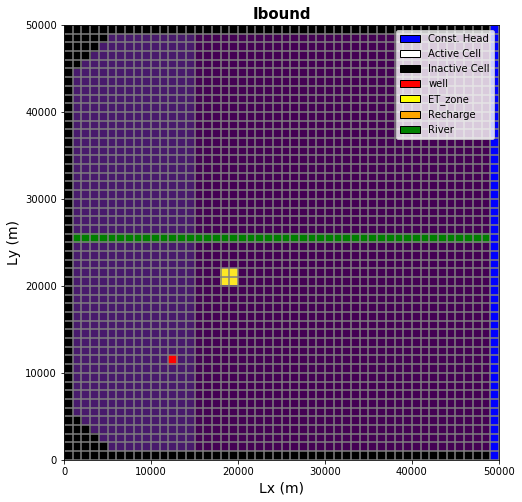

In [10]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1, aspect='equal')

modelmap = flopy.plot.PlotMapView(model=m)
grid = modelmap.plot_grid()
#zones = ET_zone + rech_zone_forced
quadmesh = modelmap.plot_array(rech_zone_forced)
#quadmesh = modelmap.plot_array(rech_zone_forced)

riv_plot = modelmap.plot_bc(ftype='RIV')
quadmesh = modelmap.plot_ibound(ibound[0])
wel = modelmap.plot_bc(ftype='WEL')
# quadmesh = modelmap.plot_array(rech_zone_forced) #, color='purple')
riv_plot = modelmap.plot_bc(ftype='RIV')
# chd_plot = modelmap.plot_bc(ftype='CHD')
# quadmesh = modelmap.plot_bc('WEL')
quadmesh = modelmap.plot_ibound()



#add labels and legend
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
plt.title('Ibound', fontsize = 15, fontweight = 'bold')
plt.legend(handles=[mp.patches.Patch(color='blue',label='Const. Head',ec='black'),
                   mp.patches.Patch(color='white',label='Active Cell',ec='black'),
                   mp.patches.Patch(color='black',label='Inactive Cell',ec='black'),
                    mp.patches.Patch(color='red',label='well',ec='black'), 
                   mp.patches.Patch(color='yellow',label='ET_zone',ec='black'),
                    mp.patches.Patch(color='orange',label='Recharge',ec='black'),
                    mp.patches.Patch(color='green',label='River',ec='black')
                   ])

plt.show(modelmap)
#plt.savefig('Domaingrid.png')

### Read in binary files

In [11]:
hds = bf.HeadFile(modelname+'.hds')                   # reads the binary head file
times = hds.get_times() # returns a list of timesteps
#times = []
# for t in range(len(perlen)):
#     if t == 0:
#         times.append(perlen[t])
#     else:
#         times.append(times[t-1]+perlen[t])
#print(times)

head = {} 
# leakage = {}
# fff = {}
# stor = {}
# recharge = {}
# et = {}
# frf = {}
headobj = flopy.utils.binaryfile.HeadFile(modelname+'.hds')
# budgobj = flopy.utils.binaryfile.CellBudgetFile(modelname+'.cbc')

print(budgobj.get_unique_record_names())

for stress_per, time in enumerate(times): #iterate through times at end of each stress period
    head['sp%s'%(stress_per)] = headobj.get_data(totim=time) #append heads to head list for ea stress per
#     leakage['sp%s'%(stress_per)] = budgobj.get_data(text='RIVER LEAKAGE',totim=time) #append right face flow to frf list for ea stress per
#     fff['sp%s'%(stress_per)] = budgobj.get_data(text='FLOW FRONT FACE',totim=time) #append front face flow to fff list for ea stress per
#     frf['sp%s'%(stress_per)] = budgobj.get_data(text='flow right face', totim=time)
#     stor['sp%s'%(stress_per)] = budgobj.get_data(text='STORAGE',totim=time)
#     recharge['sp%s'%(stress_per)] = budgobj.get_data(text='RECHARGE', totim=time) 
#     et['sp%s'%(stress_per)] = budgobj.get_data(text='ET', totim=time) 

# print(recharge.keys())
# print(recharge["sp1"])
# print(recharge["sp1199"])

NameError: name 'budgobj' is not defined

In [ ]:
# print(len(head))

### Gridded domain plot

In [ ]:
# fig = plt.figure(figsize=(15, 5))
# ax = fig.add_subplot(1, 1, 1)

# xsect = flopy.plot.PlotCrossSection(model=m, line={'row': 25}) #note use the key 'column' if you want to plot a column instaed
# patches = xsect.plot_ibound(color_noflow='red', color_ch='blue')
# #patches = xsect.plot_bc('WEL', color='red')
# # linecollection = xsect.plot_grid(color='green')
# # t = ax.set_title('Row 25 Cross-Section with IBOUND Boundary Conditions')

# pc = xsect.plot_array(head['sp1200'], masked_values=[-999.99], head=head, alpha=0.5)
# patches = xsect.plot_ibound(head=head['sp1200'])
# #patches = xsect.plot_ibound(color_noflow='red', color_ch='blue')
# #patches = xsect.plot_bc('WEL', color='red')
# linecollection = xsect.plot_grid(color='black', lw=0.5)
# t = ax.set_title('3 Layer Model Row 25 Cross-Section')
# cb = plt.colorbar(pc, shrink=0.75)
# #Overlay the head in a layer of the model- in this case I'm doing the top layer i.e. head3[0,:,:]
# wt = xsect.plot_surface(head['sp200'][0,:,:], masked_values=[999.], color='blue', lw=1)

## Plotting Heads

In [ ]:
#plot a time series at cell left of river
#get time series for cell

cell_id1 = well_loc #cell at the center of the ag area
time_series1 = headobj.get_ts(cell_id1) #get the time series using flopy

#create firt plot  
plt.subplot(1, 1, 1)
plt.title("Head at Aquaseca Well (Scen5)",fontweight='bold')
plt.xlabel('time (years)',fontweight='bold')
plt.ylabel('head (m)',fontweight='bold')
plt.ylim(74.5,76)
plt.plot(time_series1[:, 0]/360, time_series1[:, 1], 'b-', color="brown") #plot the time series with points at each record
# print(time_series1[:, 1])
plt.savefig("Head_Aqua5.png",dpi=600)
plt.show()


In [ ]:

#plot a time series at cell left of river
#get time series for cell

cell_id1 = well2_loc #cell at the center of the ag area
time_series1 = headobj.get_ts(cell_id1) #get the time series using flopy

#create firt plot  
plt.subplot(1, 1, 1)
plt.title("Head at MW1",fontweight='bold')
plt.xlabel('time (days)',fontweight='bold')
plt.ylabel('head (m)',fontweight='bold')
plt.plot(time_series1[:, 0], time_series1[:, 1], 'b-') #plot the time series with points at each record
# plt.plot(time_series1[900:, 0], time_series1[900:, 1], 'b-') #less data

plt.savefig("Head_M1_5.png",dpi=600)
plt.show()


In [ ]:

#plot a time series at cell left of river
#get time series for cell

cell_id1 = well3_loc #cell at the center of the ag area
time_series1 = headobj.get_ts(cell_id1) #get the time series using flopy

#create firt plot  
plt.subplot(1, 1, 1)
plt.title("Head at MW2",fontweight='bold')
plt.xlabel('time (years)',fontweight='bold')
plt.ylabel('head (m)',fontweight='bold')
# plt.ylim(87, 92)
plt.plot(time_series1[:, 0]/360, time_series1[:, 1], 'b-') #plot the time series with points at each record

plt.savefig("Head_M2_5png", dpi=600)
plt.show()


In [ ]:

#plot a time series at cell left of river
#get time series for cell

cell_id1 = well4_loc #cell at the center of the ag area
time_series1 = headobj.get_ts(cell_id1) #get the time series using flopy

#create firt plot  
plt.subplot(1, 1, 1)
plt.title("Head at Irrigation Well (Scen 5)",fontweight='bold')
plt.xlabel('time (years)',fontweight='bold')
plt.ylabel('head (m)',fontweight='bold')
#plt.ylim(89, 92)
plt.plot(time_series1[:, 0]/360, time_series1[:, 1], 'b-', color="magenta") #plot the time series with points at each record

plt.savefig("Head_irri5.png", dpi=600)
plt.show()


### Leakage calculation

In [ ]:
well_loc
head['sp0'][0][19][38]
#head['sp0'][well_loc[0]][well_loc[1]][well_loc[2]]

#budgobj = flopy.utils.binaryfile.CellBudgetFile(modelname+'.cbc')
#leakage = budgobj.get_data(text='RIVER LEAKAGE')
#print(leakage[0])
perflux = np.array(range(nper))

for i in range(nper-1):
    ##print("Stream Leakage for Stress period %s"%i)
    perflux[i] = 0
    for k in range(len(leakage['sp%s'%i][0])):
        #print(leakage['sp%s'%i][0][k][1])
        perflux[i] = perflux[i] + leakage['sp%s'%i][0][k][1]
        #flux[i] = flux[i] + leakage[0][k][1]
    
print(perflux)    


## Water Budget calculations

In [ ]:
print(len(head))
##STream Leakage

t2 = max(enumerate(times))
t = t2[0] - 12
print(t)
leak = 0
for i in range(12):
    leak = leak + np.sum(leakage['sp%s'%(t+i)][0].q)
print("Total stream leakge at year 100:")    
print(leak)   
# t = 0
# ileak = 0
# for i in range(12):
#     ileak = ileak + np.sum(leakage['sp%s'%(t+i)][0].q)
    
# print(int(ileak))    

##GW outflow
t = t2[0] - 12
print(t)
frf_total = 0
for k in range(nlay):
    for i in range(12):
        frf_total = frf_total + np.sum(frf['sp%s'%(t+i)][0][k][:][48])

print("Total GW outflow 100 year:")
print(frf_total)
#print(np.sum(leakage['sp0'][0].q) - np.sum(leakage['sp1199'][0].q))

## ET
t = t2[0] - 12
print(t)
ET_total = 0
for i in range(12):
       ET_total = ET_total + np.sum(np.sum(et['sp%s'%(t+i)][0][1][:][:]))
print("Total ET at year 100:")
print(ET_total) 

## Recharge
t = t2[0] - 12
print(t)
rech_total = 0
for i in range(12):
       rech_total = rech_total + np.sum(np.sum(recharge['sp%s'%(t+i)][0][1][:][:]))
print("Total rech at year 100:")
print(rech_total)     


### Testing stuff

In [ ]:
type(times)
len(times)


In [ ]:
oc_spd = {}
for kper in range(1,nper): #nper is 201, this is the key for each entry in oc_spd dict
    oc_spd[(kper, 1)] = ['save head','save drawdown','save budget','print head','print budget']
    oc_spd[(kper, 90)] = ['save head','save drawdown','save budget','print head','print budget']
    oc_spd[(kper, 179)] = ['save head','save drawdown','save budget','print head','print budget']
oc = flopy.modflow.ModflowOc(model=m, stress_period_data=oc_spd, compact=True)


### Storage

In [ ]:
# #testing things
# type(stor)
# stor.keys()
# #stor.values()

# type(stor["sp1"])
# print(stor["sp1"])

# SUM=(sum(stor["sp1"]))
# print(SUM)

# print(stor['sp1'][0][0].shape)

# startlay0 = (stor['sp0'][0][0])
# startlay1 = (stor['sp0'][0][1])
# startlay2 = (stor['sp0'][0][2])
# start_stor = startlay0 + startlay1 + startlay2
# print(start_stor.sum())

# endlay0 = (stor['sp1199'][0][0])
# endlay1 = (stor['sp1199'][0][1])
# endlay2 = (stor['sp1199'][0][2])
# end_stor = endlay0 + endlay1 + endlay2
# print(end_stor.sum())

#storage change
storage_change = 0
for i in range(sim_years*sp_peryr*nstp[0]):
    storage_i = stor['sp%s'%(i)][0][:].sum()
    storage_change = storage_change + storage_i
print(storage_change)

#yearly storage
yearly_stor = {}
storage_change = 0
yearlist = list(range(100))
for i in range(len(yearlist)):
    yearlist[i] = yearlist[i]*12
#print(yearlist)

for i in yearlist:
    storage_change = 0
    for sp in range(12):
        timestep = i + sp
        storage_i = stor['sp%s'%(timestep)][0][:].sum()
        storage_change = storage_change + storage_i
        #print(storage_change)
        if sp == 11:
            yearly_stor[i/12] = storage_change
            print('year', i/12, storage_change)
            
            
#more storage stuff
storage_tot = 0
for i in range(100):
    storage_tot = storage_tot + yearly_stor[i]
    
print(storage_tot)
print(0.000810714*storage_tot)


yearlist2 = list(range(100))
print(yearlist2)
print(type(yearly_stor))
stor_ls = []
for i in range(100):
    stor_ls.append(yearly_stor[i])
  

In [ ]:
plt.subplot(1, 1, 1)
plt.title("Change in Storage",fontweight='bold')
plt.xlabel('Year',fontweight='bold')
plt.ylabel('Change Storage',fontweight='bold')
plt.plot(yearlist2, stor_ls, 'b-', color="darkblue") #plot the time series with points at each record
# plt.savefig('storage.png', dpi=600)
plt.show()


#### Cumulative storage

In [ ]:
cum_storage_ls = []
cum_storage = 0
for i in range(100):
    cum_storage = cum_storage + yearly_stor[i]
    cum_storage_ls.append(cum_storage)
    

In [ ]:
plt.subplot(1, 1, 1)
plt.title("Cumulative Change in Storage",fontweight='bold')
plt.xlabel('Year',fontweight='bold')
plt.ylabel('Change Storage',fontweight='bold')
plt.plot(yearlist2, cum_storage_ls, 'b-', color="purple") #plot the time series with points at each record
# plt.savefig('cumstorage.png', dpi=600)
plt.show()


In [12]:
#rech_rows_forced2 = (28.0, 30.0) 
#rech_cols_forced2 = (18, 20)
moddirmp="C:\mpath7"
#locsb = [[0, z2_rowur, z2_colll, 0, z2_rowll, z2_colur]]
locsb = [[0, 28, 18, 0, 30, 20]]
sd= flopy.modpath.CellDataType(drape=0, columncelldivisions=3, rowcelldivisions=3, layercelldivisions=3)
p= flopy.modpath.LRCParticleData(subdivisiondata=[sd], lrcregions=[locsb])
pg1 = flopy.modpath.ParticleGroupLRCTemplate(particlegroupname='PG1',particledata=p,filename='ex01a.pg1.sloc')
particlegroups = [pg1]

defaultiface = {'RECHARGE': 6, 'ET': 6}

mpname3=os.path.join(modelname + '_mp')
print(mpname3)
mp3 = flopy.modpath.Modpath7(modelname=modelname + '_mp', flowmodel=m, exe_name=moddirmp)
mpbas = flopy.modpath.Modpath7Bas(mp3, porosity=n, defaultiface=defaultiface)
mpsim = flopy.modpath.Modpath7Sim(mp3, simulationtype='combined',
                                  trackingdirection='forward',
                                  weaksinkoption='stop_at',
                                  weaksourceoption='stop_at',
                                  budgetoutputoption='summary',
                                  stoptimeoption='extend', 
                                  particlegroups= particlegroups)


mp3.add_package(rch)
mp3.add_package(evt)
mp3.write_input()
mp3.run_model()
mp3.get_package_list()

Ensemble_Testing_2121331_mp
FloPy is using the following  executable to run the model: C:\mpath7.exe

MODPATH Version 7.2.001   
Program compiled Dec 22 2017 11:11:36 with IFORT compiler (ver. 16.0.0)         
 
 
Run particle tracking simulation ...
Processing Time Step     1 Period     1.  Time =  3.60000E+02  Transient flow                                                       
Processing Time Step     1 Period     2.  Time =  7.20000E+02  Transient flow                                                       
Processing Time Step     1 Period     3.  Time =  1.08000E+03  Transient flow                                                       
Processing Time Step     1 Period     4.  Time =  1.44000E+03  Transient flow                                                       
Processing Time Step     1 Period     5.  Time =  1.80000E+03  Transient flow                                                       
Processing Time Step     1 Period     6.  Time =  2.16000E+03  Transient flow       

Processing Time Step     1 Period    61.  Time =  2.19600E+04  Transient flow                                                       
Processing Time Step     1 Period    62.  Time =  2.23200E+04  Transient flow                                                       
Processing Time Step     1 Period    63.  Time =  2.26800E+04  Transient flow                                                       
Processing Time Step     1 Period    64.  Time =  2.30400E+04  Transient flow                                                       
Processing Time Step     1 Period    65.  Time =  2.34000E+04  Transient flow                                                       
Processing Time Step     1 Period    66.  Time =  2.37600E+04  Transient flow                                                       
Processing Time Step     1 Period    67.  Time =  2.41200E+04  Transient flow                                                       
Processing Time Step     1 Period    68.  Time =  2.44800E+04  Transi

['MPBAS', 'MPSIM', 'RCH', 'EVT']

In [21]:
# ### 3 layer model 
# #Particle pathlines
fpth3 = os.path.join(mpname3 + '.mppth')
p3 = flopy.utils.PathlineFile(fpth3)

# #Particle endpoints
fpth3 = os.path.join(mpname3 + '.mpend')
e = flopy.utils.EndpointFile(fpth3, verbose=False)

# #make a subset which is all the particles
pall3 = p3.get_alldata()  
# #eall3 = e3.get_alldata()
# 2,well_row, well_col      
#make a subset which is particles ending in the well
nodewell3 = m.dis.get_node([(2,well_row, well_col)])
print(nodewell3)
#pwell3 = p.get_destination_pathline_data(dest_cells=nodewell3)
ewell3 = e.get_destination_endpoint_data(dest_cells=nodewell3)

[6487]


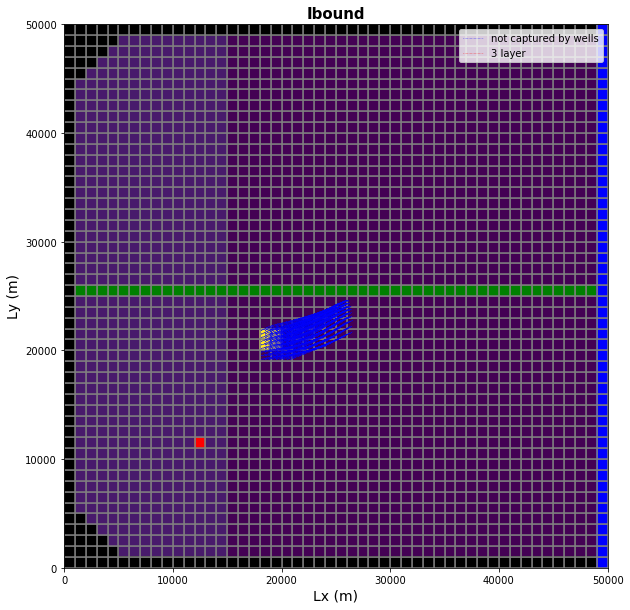

In [44]:
well = [0,well_row, well_col]
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)

ax.set_aspect('equal')
ax.set_title('3 Layer Scenario Flowlines')

mm = flopy.plot.PlotMapView(model=m, ax=ax)
modelmap = flopy.plot.PlotMapView(model=m)
grid = modelmap.plot_grid()
#zones = ET_zone + rech_zone_forced
quadmesh = modelmap.plot_array(rech_zone_forced)
#quadmesh = modelmap.plot_array(rech_zone_forced)

riv_plot = modelmap.plot_bc(ftype='RIV')
quadmesh = modelmap.plot_ibound(ibound[0])
wel = modelmap.plot_bc(ftype='WEL')
# quadmesh = modelmap.plot_array(rech_zone_forced) #, color='purple')
riv_plot = modelmap.plot_bc(ftype='RIV')
# chd_plot = modelmap.plot_bc(ftype='CHD')
# quadmesh = modelmap.plot_bc('WEL')
quadmesh = modelmap.plot_ibound()



#add labels and legend
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
plt.title('Ibound', fontsize = 15, fontweight = 'bold')
plt.legend(handles=[mp.patches.Patch(color='blue',label='Const. Head',ec='black'),
                   mp.patches.Patch(color='white',label='Active Cell',ec='black'),
                   mp.patches.Patch(color='black',label='Inactive Cell',ec='black'),
                    mp.patches.Patch(color='red',label='well',ec='black'), 
                   mp.patches.Patch(color='yellow',label='ET_zone',ec='black'),
                    mp.patches.Patch(color='orange',label='Recharge',ec='black'),
                    mp.patches.Patch(color='green',label='River',ec='black')
                   ])

#plt.show(modelmap)
mm.plot_grid(lw=0.5)
mm.plot_pathline(pall3, layer='all', color='blue', lw=0.5, linestyle=':', label='not captured by wells') #,marker='o', markercolor='black', markersize=3, markerevery=5)
#mm.plot_pathline(pwell3, layer=1, color='red', lw=0.5, linestyle=':', label='3 layer') # ,marker='o', markercolor='black', markersize=3, markerevery=5)
mm.plot_pathline(ewell3, layer='all', color='red', lw=0.5, linestyle=':', label='3 layer') # ,marker='o', markercolor='black', markersize=3, markerevery=5)
mm.ax.legend();